本研究部分进一步深化了经济发展水平与二氧化碳排放量之间关系的探讨，将其纳入Box-Cox模型的框架中进行分析。特别的，在此将分别基于不同的自变量组合对模型进行估计。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro
import seaborn as sns
from scipy.special import boxcox1p
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import boxcox
plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

C:\Users\Yvett\AppData\Local\Temp\ipykernel_17012\3118313684.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#加载数据
df = pd.read_csv('经济发展水平与二氧化碳排放关系分析.csv')
print(df.head())

        co2     density           fdi      trade        gdp1          gdp2
0  0.223479   59.752281  2.425833e+07  46.709895    512.0551  2.000000e+10
1  1.544550  103.571130 -1.020000e+09  59.829729   5343.0377  1.520000e+10
2  3.718223   18.243657 -1.130000e+09  40.389757   3794.4095  1.650000e+11
3  0.592743   26.813577  1.960000e+09  65.942029   1450.9051  4.850000e+10
4  5.121730  210.600000 -1.050000e+08  94.345720  15224.8590  1.410000e+09


首先，为了能够更好地了解样本数据的分布特性，我们对样本因变量人均二氧化碳排放量（CO2）分别绘制样本分布图和Q-Q图，以判断CO2_i是否服从正态分布。如下图所示，因变量的分布形态呈现出明显的非对称性，与正态分布的期望特征相去甚远。此外，通过Shapiro–Wilk正态性检验，我们得到了几乎为0的p值，确实拒绝了数据服从正态分布的原假设。

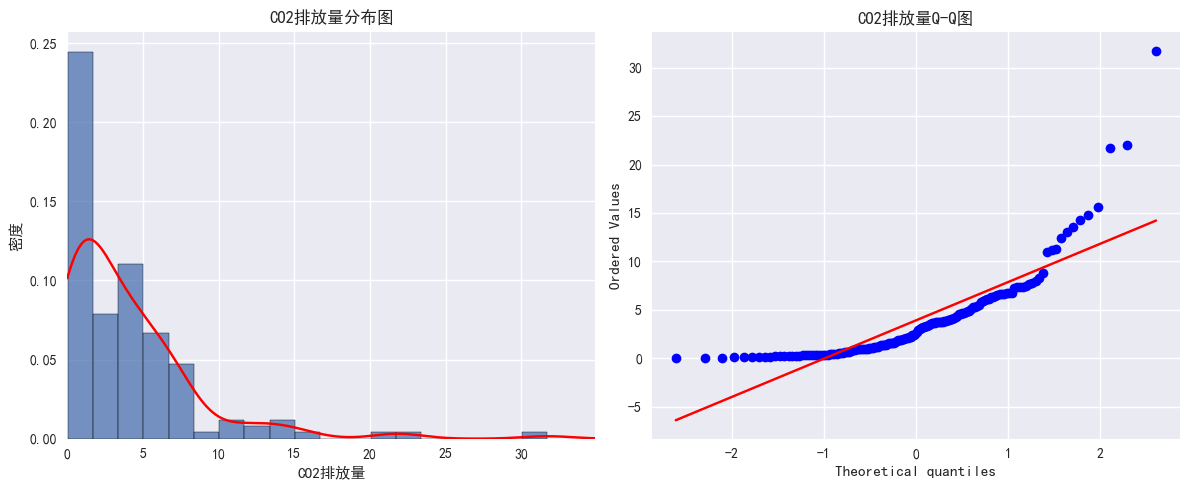

Shapiro-Wilk检验结果：
统计量=0.7366, p值=3.3537e-15


In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df, x='co2', stat='density', ax=ax1)
sns.kdeplot(data=df, x='co2', color='red', clip=(0, None), ax=ax1)
ax1.set_xlim(0, df['co2'].max() * 1.1)
ax1.set_title('CO2排放量分布图')
ax1.set_xlabel('CO2排放量')
ax1.set_ylabel('密度')

stats.probplot(df['co2'], dist="norm", plot=ax2)
ax2.set_title('CO2排放量Q-Q图')
plt.tight_layout()
plt.show()

#Shapiro-Wilk检验
stat, p_value = shapiro(df['co2'])
print(f'Shapiro-Wilk检验结果：\n统计量={stat:.4f}, p值={p_value:.4e}')

鉴于此，可以考虑对数据进行Box-Cox变换，这将有助于改善数据的分布形态，并可能提高模型的拟合度。我们在此同样将分别估计最高次项阶数r=1,2,3的三种不同模型。

In [6]:
def compute_jacobian(y, lambda_param):
    return np.prod(y**(lambda_param - 1))

def boxcox_transform(y, lambda_param):
    """计算Box-Cox变换"""
    if lambda_param == 0:
        return np.log(y)
    else:
        return (y**lambda_param - 1) / lambda_param

def compute_log_likelihood(y, X, lambda_param):
    """计算对数似然函数值"""
    n = len(y)
    y_transformed = boxcox_transform(y, lambda_param)
    X = np.column_stack((np.ones(len(X)), X)) 
    beta = np.linalg.inv(X.T @ X) @ X.T @ y_transformed
    y_pred = X @ beta
    residuals = y_transformed - y_pred
    sigma2 = np.sum(residuals**2) / n
    
    log_jacobian = np.log(compute_jacobian(y, lambda_param))
    quad_term = np.sum((y_transformed - y_pred)**2)
    ll = -n/2 * np.log(2*np.pi) - n/2 * np.log(sigma2) \
         - quad_term/(2*sigma2) + log_jacobian    
    
    return ll



模型1 (线性ln(GDP)):
最优λ值: 0.120
95%置信区间: [0.050, 0.200]

模型2 (二次ln(GDP)):
最优λ值: 0.010
95%置信区间: [-0.070, 0.090]

模型3 (三次ln(GDP)):
最优λ值: 0.020
95%置信区间: [-0.060, 0.100]


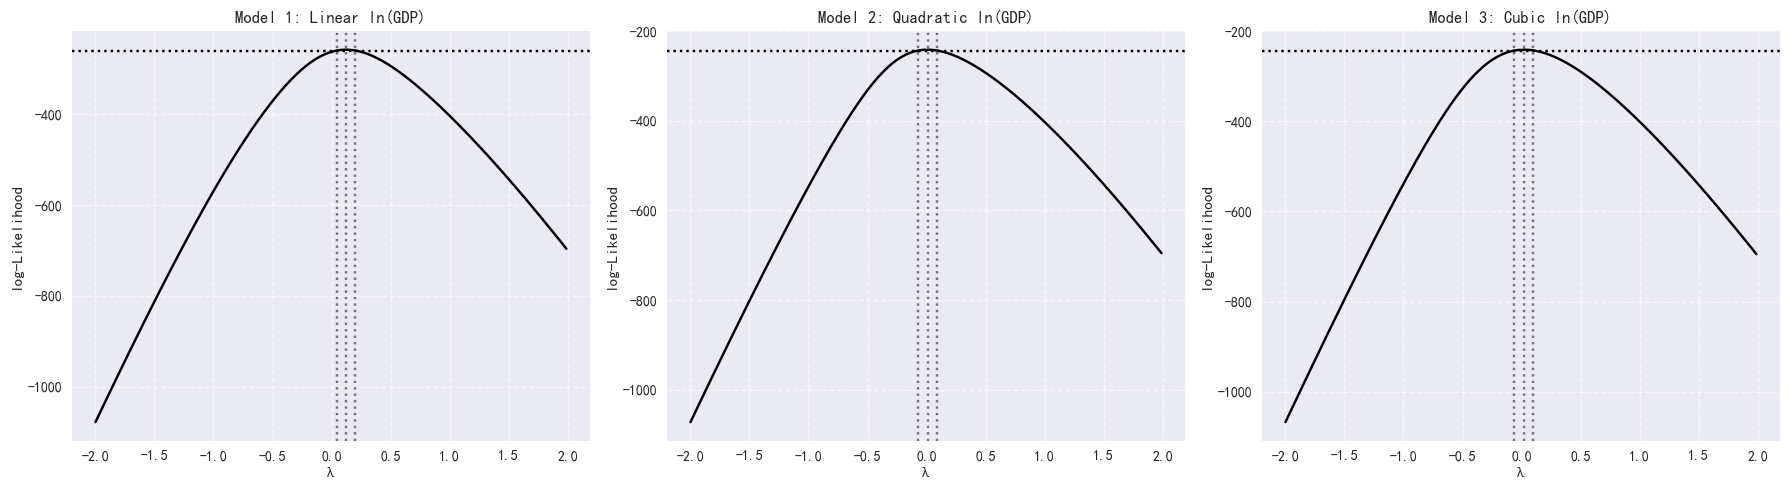

In [7]:
#数据
y = df['co2'].values
ln_gdp = np.log(df['gdp1'])
ln_gdp_sq = ln_gdp**2
ln_gdp_cube = ln_gdp**3

#三种不同的X矩阵
X1 = np.column_stack((
    ln_gdp,           
    df['density'],    
    df['fdi'],      
    df['trade']      
))

X2 = np.column_stack((
    ln_gdp,          
    ln_gdp_sq,       
    df['density'],    
    df['fdi'],       
    df['trade']     
))

X3 = np.column_stack((
    ln_gdp,          
    ln_gdp_sq,       
    ln_gdp_cube,     
    df['density'],   
    df['fdi'],      
    df['trade']    
))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
lambda_range = np.arange(-2, 2, 0.01)

#模型1
ll_values1 = [compute_log_likelihood(y, X1, l) for l in lambda_range]
optimal_lambda1 = lambda_range[np.argmax(ll_values1)]
threshold1 = max(ll_values1) - 1.96
ci_indices1 = np.where(ll_values1 >= threshold1)[0]
ci_lambda_low1 = lambda_range[ci_indices1[0]]
ci_lambda_high1 = lambda_range[ci_indices1[-1]]

ax1.plot(lambda_range, ll_values1, 'k-')
ax1.axhline(y=max(ll_values1) - 1.96, color='k', linestyle=':', label='95% CI')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.axvline(x=ci_lambda_low1, color='k', linestyle=':', alpha=0.5)
ax1.axvline(x=optimal_lambda1, color='k', linestyle=':', alpha=0.5)
ax1.axvline(x=ci_lambda_high1, color='k', linestyle=':', alpha=0.5)
ax1.set_xlabel('λ')
ax1.set_ylabel('log-Likelihood')
ax1.set_title('Model 1: Linear ln(GDP)')

#模型2
ll_values2 = [compute_log_likelihood(y, X2, l) for l in lambda_range]
optimal_lambda2 = lambda_range[np.argmax(ll_values2)]
threshold2 = max(ll_values2) - 1.96
ci_indices2 = np.where(ll_values2 >= threshold2)[0]
ci_lambda_low2 = lambda_range[ci_indices2[0]]
ci_lambda_high2 = lambda_range[ci_indices2[-1]]

ax2.plot(lambda_range, ll_values2, 'k-')
ax2.axhline(y=max(ll_values2) - 1.96, color='k', linestyle=':', label='95% CI')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.axvline(x=ci_lambda_low2, color='k', linestyle=':', alpha=0.5)
ax2.axvline(x=optimal_lambda2, color='k', linestyle=':', alpha=0.5)
ax2.axvline(x=ci_lambda_high2, color='k', linestyle=':', alpha=0.5)
ax2.set_xlabel('λ')
ax2.set_ylabel('log-Likelihood')
ax2.set_title('Model 2: Quadratic ln(GDP)')

#模型3
ll_values3 = [compute_log_likelihood(y, X3, l) for l in lambda_range]
optimal_lambda3 = lambda_range[np.argmax(ll_values3)]
threshold3 = max(ll_values3) - 1.96
ci_indices3 = np.where(ll_values3 >= threshold3)[0]
ci_lambda_low3 = lambda_range[ci_indices3[0]]
ci_lambda_high3 = lambda_range[ci_indices3[-1]]

ax3.plot(lambda_range, ll_values3, 'k-')
ax3.axhline(y=max(ll_values3) - 1.96, color='k', linestyle=':', label='95% CI')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.axvline(x=ci_lambda_low3, color='k', linestyle=':', alpha=0.5)
ax3.axvline(x=optimal_lambda3, color='k', linestyle=':', alpha=0.5)
ax3.axvline(x=ci_lambda_high3, color='k', linestyle=':', alpha=0.5)
ax3.set_xlabel('λ')
ax3.set_ylabel('log-Likelihood')
ax3.set_title('Model 3: Cubic ln(GDP)')

plt.tight_layout()

print("模型1 (线性ln(GDP)):")
print(f"最优λ值: {optimal_lambda1:.3f}")
print(f"95%置信区间: [{ci_lambda_low1:.3f}, {ci_lambda_high1:.3f}]\n")

print("模型2 (二次ln(GDP)):")
print(f"最优λ值: {optimal_lambda2:.3f}")
print(f"95%置信区间: [{ci_lambda_low2:.3f}, {ci_lambda_high2:.3f}]\n")

print("模型3 (三次ln(GDP)):")
print(f"最优λ值: {optimal_lambda3:.3f}")
print(f"95%置信区间: [{ci_lambda_low3:.3f}, {ci_lambda_high3:.3f}]")

plt.show()

观察上图可以发现，在模型（1）中，当变换参数λ在0.1附近时，似然函数达到峰值，因此我们选择这一参数值进行相应的变化处理，从而得到CO2_i^((0.1))。对于模型（2）和模型（3），似然函数均在变换参数λ为0时达到最大值，这意味着可以对数据进行对数变换，得到CO2_i^((0))，即对数取值ln⁡CO2_i。变换完成后，进一步基于不同的自变量组合构造线性回归模型，估计系数汇总于下表中。通过对比分析，我们发现这些估计结果与8.2节中的结果具有很高的一致性。特别地，在包含立方项的多项式回归模型中，人均GDP立方项和平方项的系数并不显著。相比之下，在包含一次项和二次项的线性回归模型中，人均GDP最高阶的回归项均在1%的显著性水平下统计显著，且估计得到的系数值非常接近。

In [8]:
def fit_model(y, X, lambda_param):
    """拟合模型并计算统计量"""
    #Box-Cox转换因变量
    if lambda_param == 0:
        y_transformed = np.log(y)
    else:
        y_transformed = (y**lambda_param - 1) / lambda_param
    
    #添加常数项
    X = np.column_stack((np.ones(len(X)), X))
    
    #回归系数
    beta = np.linalg.inv(X.T @ X) @ X.T @ y_transformed
    
    #拟合值和残差
    y_pred = X @ beta
    residuals = y_transformed - y_pred
    
    #样本量和自由度
    n = len(y)
    k = X.shape[1]  # 包括常数项的参数个数
    df = n - k
    
    #残差平方和、标准误
    rss = np.sum(residuals**2)
    mse = rss / df
    var_beta = mse * np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(var_beta))

    t_stats = beta / se
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))
    y_mean = np.mean(y_transformed)
    tss = np.sum((y_transformed - y_mean)**2)
    r_squared = 1 - rss/tss
    adj_r_squared = 1 - (1 - r_squared) * (n - 1)/(n - k)
    f_stat = (r_squared/(k-1))/((1-r_squared)/df)
    f_p_value = 1 - stats.f.cdf(f_stat, k-1, df)
    
    return {
        'coefficients': beta,
        'std_errors': se,
        't_stats': t_stats,
        'p_values': p_values,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'f_stat': f_stat,
        'f_p_value': f_p_value,
        'n_obs': n,
        'df': df,
        'residuals': residuals
    }

y = df['co2'].values
ln_gdp = np.log(df['gdp1'])
ln_gdp_sq = ln_gdp**2
ln_gdp_cube = ln_gdp**3
X1 = np.column_stack((ln_gdp, df['density'], df['fdi'], df['trade']))
X2 = np.column_stack((ln_gdp, ln_gdp_sq, df['density'], df['fdi'], df['trade']))
X3 = np.column_stack((ln_gdp, ln_gdp_sq, ln_gdp_cube, df['density'], df['fdi'], df['trade']))

var_names1 = ['const', 'ln(gdp)', 'density', 'fdi', 'trade']
var_names2 = ['const', 'ln(gdp)', 'ln(gdp)²', 'density', 'fdi', 'trade']
var_names3 = ['const', 'ln(gdp)', 'ln(gdp)²', 'ln(gdp)³', 'density', 'fdi', 'trade']

#拟合三个模型
results1 = fit_model(y, X1, 0.1)  # 模型1，lambda=0.1
results2 = fit_model(y, X2, 0)    # 模型2，lambda=0
results3 = fit_model(y, X3, 0)    # 模型3，lambda=0

def print_results(results, var_names, model_name):
    print(f"\n{model_name}")
    print("="*80)
    print(f"{'Variable':<15} {'Coefficient':>12} {'Std.Error':>12} {'t-value':>12} {'P>|t|':>12}")
    print("-"*80)
    
    for i, name in enumerate(var_names):
        print(f"{name:<15} {results['coefficients'][i]:12.4f} {results['std_errors'][i]:12.4f} "
              f"{results['t_stats'][i]:12.4f} {results['p_values'][i]:12.4f}")
    
    print("-"*80)
    print(f"Observations: {results['n_obs']}")
    print(f"Degrees of Freedom: {results['df']}")
    print(f"R-squared: {results['r_squared']:.4f}")
    print(f"Adj R-squared: {results['adj_r_squared']:.4f}")
    print(f"F-statistic: {results['f_stat']:.4f}")
    print(f"Prob (F-statistic): {results['f_p_value']:.4f}")
    print("="*80)

print_results(results1, var_names1, "Model 1 (λ = 0.1)")
print_results(results2, var_names2, "Model 2 (λ = 0)")
print_results(results3, var_names3, "Model 3 (λ = 0)")


Model 1 (λ = 0.1)
Variable         Coefficient    Std.Error      t-value        P>|t|
--------------------------------------------------------------------------------
const                -6.7206       0.3794     -17.7135       0.0000
ln(gdp)               0.8639       0.0460      18.7631       0.0000
density              -0.0001       0.0001      -0.6452       0.5198
fdi                  -0.0000       0.0000      -0.0674       0.9463
trade                -0.0000       0.0013      -0.0350       0.9721
--------------------------------------------------------------------------------
Observations: 152
Degrees of Freedom: 147
R-squared: 0.7370
Adj R-squared: 0.7298
F-statistic: 102.9807
Prob (F-statistic): 0.0000

Model 2 (λ = 0)
Variable         Coefficient    Std.Error      t-value        P>|t|
--------------------------------------------------------------------------------
const               -19.4246       1.9242     -10.0949       0.0000
ln(gdp)               3.8405       0.4447     


Model 2 残差分析结果

1. Shapiro-Wilk正态性检验:
   统计量: 0.9860
   p值: 0.1287
   结论: 不能拒绝正态性假设 (α = 0.05)

2. 描述性统计:
   均值: 0.0000
   中位数: -0.0530
   标准差: 0.5988
   偏度: 0.2918
   峰度: -0.2407


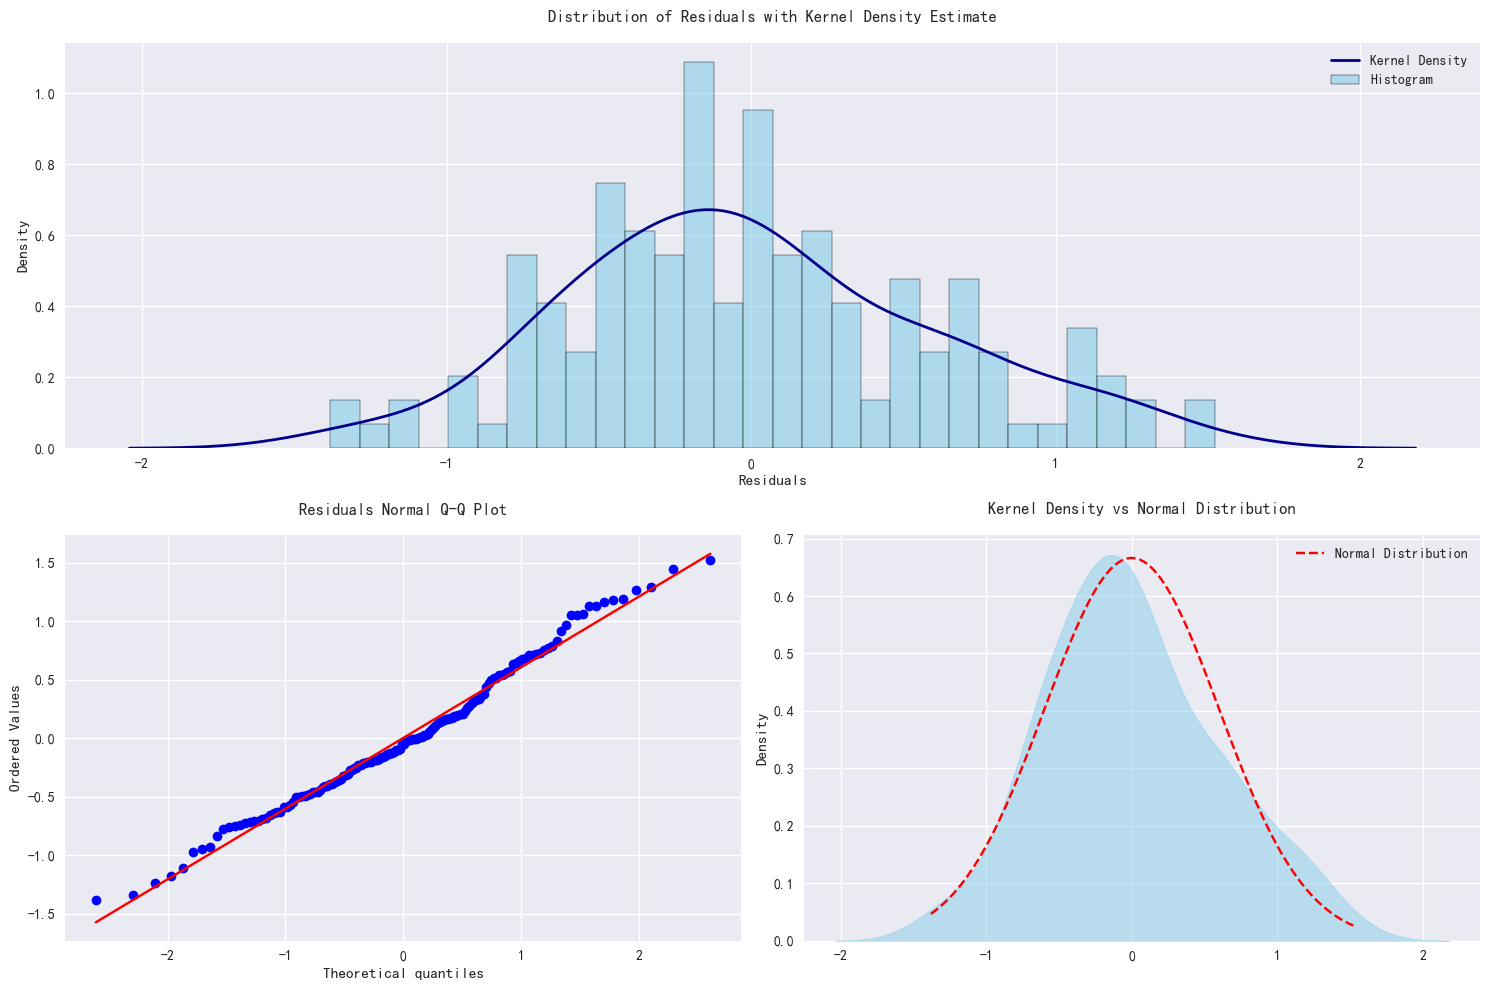

In [15]:
def analyze_residuals(residuals, model_name, figsize=(15, 10)):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2)
    
    #残差分布直方图
    ax1 = fig.add_subplot(gs[0, 0:2])
    hist = sns.histplot(residuals, kde=False, bins=30, color='skyblue', alpha=0.6, label='Histogram', stat='density')  
    kde = sns.kdeplot(residuals, color='darkblue', linewidth=2, label='Kernel Density')
    ax1.set_title('Distribution of Residuals with Kernel Density Estimate', fontsize=12, pad=15)
    ax1.set_xlabel('Residuals')
    ax1.set_ylabel('Density') 
    ax1.legend()
#     ax1 = fig.add_subplot(gs[0, 0:2])
#     sns.histplot(residuals, kde=True, bins=30, color='skyblue', alpha=0.6)
#     kde1 = sns.kdeplot(residuals, color='skyblue', linewidth=2, label='KDE (histogram)')
#     kde2 = sns.kdeplot(residuals, color='darkblue', linewidth=2, label='KDE (kernel)')
#     ax1.set_title('Distribution of Residuals with Kernel Density Estimate',fontsize=12, pad=15)
#     ax1.set_xlabel('Residuals')
#     ax1.set_ylabel('Frequency')
#     ax1.legend()

    
    #残差Q-Q图
    ax2 = fig.add_subplot(gs[1, 0])
    qq = stats.probplot(residuals, dist="norm", plot=ax2)
    ax2.set_title('Residuals Normal Q-Q Plot', fontsize=12, pad=15)
    
    #残差核密度估计与正态分布比较
    ax3 = fig.add_subplot(gs[1, 1])
    kde = sns.kdeplot(data=residuals, fill=True, color='skyblue', alpha=0.5)
    x_range = np.linspace(residuals.min(), residuals.max(), 100)
    norm_rv = stats.norm(np.mean(residuals), np.std(residuals))
    ax3.plot(x_range, norm_rv.pdf(x_range), 'r--', label='Normal Distribution')
    ax3.set_title('Kernel Density vs Normal Distribution', fontsize=12, pad=15)
    ax3.legend()
    
    plt.tight_layout()
    
    #Shapiro-Wilk检验
    stat, p_value = stats.shapiro(residuals)
    
    #描述性统计量
    desc_stats = {
        'Mean': np.mean(residuals),
        'Median': np.median(residuals),
        'Std Dev': np.std(residuals),
        'Skewness': stats.skew(residuals),
        'Kurtosis': stats.kurtosis(residuals)
    }
    
    print(f"\n{model_name} 残差分析结果")
    print("="*60)
    print("\n1. Shapiro-Wilk正态性检验:")
    print(f"   统计量: {stat:.4f}")
    print(f"   p值: {p_value:.4f}")
    print(f"   结论: {'拒绝正态性假设' if p_value < 0.05 else '不能拒绝正态性假设'} (α = 0.05)")
    
    print("\n2. 描述性统计:")
    print(f"   均值: {desc_stats['Mean']:.4f}")
    print(f"   中位数: {desc_stats['Median']:.4f}")
    print(f"   标准差: {desc_stats['Std Dev']:.4f}")
    print(f"   偏度: {desc_stats['Skewness']:.4f}")
    print(f"   峰度: {desc_stats['Kurtosis']:.4f}")
    print("="*60)
    
    plt.show()

#调用函数以分析
residuals = results2['residuals']
analyze_residuals(residuals, "Model 2")